# PPO Rotation Alignment Agent (Tetris Chiral Shapes)

This notebook trains a minimal PPO agent on the same Tetris *chiral shapes* dataset used in
`exhaustive_search.ipynb` and `dqn_tetris.ipynb`. We use the Stable-Baselines3 baseline PPO implementation
and keep the setup intentionally barebones.

SB3 PPO docs: [https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)


In [19]:
%cd /Users/masha/Documents/visual-reasoning

/Users/masha/Documents/visual-reasoning


In [20]:
import math
import random
from typing import Callable, Optional, Tuple

import numpy as np
import cv2
import torch
import torch.nn.functional as F
import kornia as K

import gymnasium as gym

from stable_baselines3 import PPO


Utility helpers: device selection, seeding, a state builder that concatenates source/target/angle channels,
and a Kornia-based rotation helper.


In [21]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def set_seed(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def build_state(source: torch.Tensor, target: torch.Tensor, angle_deg=None) -> torch.Tensor:
    # Build state by concatenating source, target, and a constant angle channel.
    # Handles batch expansion of target/angle if needed.
    if source.dim() == 3:
        source = source.unsqueeze(0)
    if target.dim() == 3:
        target = target.unsqueeze(0)
    if target.shape[0] == 1 and source.shape[0] > 1:
        target = target.expand(source.shape[0], -1, -1, -1)

    state = torch.cat([source, target], dim=1)

    if angle_deg is None:
        return state

    if not torch.is_tensor(angle_deg):
        angle = torch.tensor([angle_deg], device=state.device, dtype=state.dtype)
    else:
        angle = angle_deg.to(device=state.device, dtype=state.dtype)

    if angle.dim() == 0:
        angle = angle.unsqueeze(0)
    if angle.numel() == 1 and state.shape[0] > 1:
        angle = angle.repeat(state.shape[0])

    angle_norm = (angle % 360.0) / 360.0
    angle_ch = angle_norm.view(-1, 1, 1, 1).expand(-1, 1, state.shape[2], state.shape[3])
    return torch.cat([state, angle_ch], dim=1)


def rotate_tensor(img: torch.Tensor, angle_deg, pad_to_diag: bool = True) -> torch.Tensor:
    # Rotate image(s) by angle(s) in degrees using kornia.
    # If pad_to_diag=True, pad to the diagonal size before rotating, then center-crop.
    if img.dim() == 3:
        img_b = img.unsqueeze(0)
    else:
        img_b = img

    if not torch.is_tensor(angle_deg):
        angle = torch.tensor([angle_deg], device=img_b.device, dtype=img_b.dtype)
    else:
        angle = angle_deg.to(device=img_b.device, dtype=img_b.dtype)

    if angle.dim() == 0:
        angle = angle.unsqueeze(0)
    if angle.numel() == 1 and img_b.shape[0] > 1:
        angle = angle.repeat(img_b.shape[0])

    b, c, h, w = img_b.shape
    if pad_to_diag:
        diag = int(math.ceil(math.sqrt(h * h + w * w)))
        pad_h = max(0, diag - h)
        pad_w = max(0, diag - w)
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        if pad_h > 0 or pad_w > 0:
            img_p = F.pad(img_b, (pad_left, pad_right, pad_top, pad_bottom), mode="constant", value=0.0)
        else:
            img_p = img_b
    else:
        img_p = img_b

    rotated = K.geometry.transform.rotate(img_p, angle)

    if pad_to_diag:
        hh, ww = h, w
        y0 = (rotated.shape[2] - hh) // 2
        x0 = (rotated.shape[3] - ww) // 2
        rotated = rotated[:, :, y0:y0 + hh, x0:x0 + ww]

    return rotated if img.dim() == 4 else rotated.squeeze(0)


device = get_device()
print("Device:", device)


Device: mps


Tetris *chiral shapes* generator (same family as `exhaustive_search.ipynb` and `dqn_tetris.ipynb`).
We keep a small subset used in exhaustive search, but you can switch to the full set by setting
`shape_keys=None` when building the sampler.


In [22]:
CHIRAL_SHAPES = {
    'L': [(0, -1), (0, 0), (0, 1), (1, 1)],
    'J': [(0, -1), (0, 0), (0, 1), (-1, 1)],
    'S': [(0, 0), (1, 0), (0, 1), (-1, 1)],
    'Z': [(0, 0), (-1, 0), (0, 1), (1, 1)],
    'F': [(0, 0), (0, -1), (1, -1), (-1, 0), (0, 1)],
    'P': [(0, 0), (0, -1), (1, -1), (1, 0), (0, 1)],
}

# Smaller subset used in exhaustive_search.ipynb
EXHAUSTIVE_SHAPE_KEYS = ("L", "Z", "S")


def draw_shape_np(name: str, size: int) -> np.ndarray:
    img = np.zeros((size, size), dtype=np.uint8)
    center = size // 2
    block_size = size // 8
    for dx, dy in CHIRAL_SHAPES[name]:
        x = center + (dx * block_size) - (block_size // 2)
        y = center + (dy * block_size) - (block_size // 2)
        cv2.rectangle(img, (x, y), (x + block_size, y + block_size), 255, -1)
    return img


_TETRIS_CACHE = {}


def get_tetris_tensor(name: str, size: int, channels: int = 3) -> torch.Tensor:
    key = (name, size, channels)
    if key in _TETRIS_CACHE:
        return _TETRIS_CACHE[key]
    img = draw_shape_np(name, size)
    t = torch.tensor(img).float().unsqueeze(0) / 255.0  # (1, H, W) in [0, 1]
    if channels == 3:
        t = t.repeat(3, 1, 1)  # (3, H, W)
    _TETRIS_CACHE[key] = t
    return t


def make_tetris_pair_sampler(
    image_shape: Tuple[int, int, int],
    mirror_prob: float = 0.5,
    angle_step: float = 5.0,
    shape_keys=None,
) -> Callable[[torch.device], Tuple[torch.Tensor, torch.Tensor, bool]]:
    c, h, w = image_shape
    keys = list(CHIRAL_SHAPES.keys()) if shape_keys is None else list(shape_keys)

    def sampler(device: torch.device):
        key = random.choice(keys)
        target = get_tetris_tensor(key, h, channels=c)
        is_mirrored = random.random() < mirror_prob
        source = torch.flip(target, dims=[2]) if is_mirrored else target.clone()
        angle = random.choice(np.arange(0.0, 360.0, angle_step))
        source = rotate_tensor(source, angle)
        return source, target, is_mirrored

    return sampler


Gymnasium environment with discrete rotation actions (larger steps: 30°, 15°, 2°) plus match/mismatch commits.
Observations are NumPy arrays so SB3 can consume them directly.


In [23]:
class RotationEnv(gym.Env):
    # Observation: (7, H, W) = [source(3), target(3), angle(1)] in [0, 1]
    # Actions:
    #   0: rotate CW  (delta = -30 deg)
    #   1: rotate CCW (delta = +30 deg)
    #   2: rotate CW  (delta = -15 deg)
    #   3: rotate CCW (delta = +15 deg)
    #   4: rotate CW  (delta = -2 deg)
    #   5: rotate CCW (delta = +2 deg)
    #   6: commit match (only allowed if error < epsilon; bonus if error is tiny)
    #   7: commit mismatch (only allowed after N steps without improvement)

    metadata = {"render_modes": []}

    def __init__(
        self,
        image_shape: Tuple[int, int, int],
        max_steps: int = 180,
        epsilon: float = 0.03,
        commit_bonus: float = 20.0,
        commit_bonus_eps: Optional[float] = None,
        mismatch_patience: int = 20,
        improve_eps: float = 1e-6,
        device: Optional[torch.device] = None,
        pair_sampler: Optional[Callable[[torch.device], Tuple[torch.Tensor, torch.Tensor, bool]]] = None,
    ):
        super().__init__()
        self.image_shape = image_shape  # (3, H, W)
        self.max_steps = max_steps
        self.epsilon = epsilon
        self.commit_bonus = commit_bonus
        self.commit_bonus_eps = commit_bonus_eps if commit_bonus_eps is not None else 0.5 * epsilon
        self.mismatch_patience = mismatch_patience
        self.improve_eps = improve_eps
        self.device = device or get_device()
        self.pair_sampler = pair_sampler

        _, h, w = image_shape
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(7, h, w),
            dtype=np.float32,
        )
        self.action_space = gym.spaces.Discrete(8)

        self.base_source = None
        self.target = None
        self.current_source = None
        self.current_angle = 0.0
        self.is_mirrored = False
        self.step_count = 0
        self.prev_error = None
        self.no_improve_steps = 0

    def _set_pair(self, source: torch.Tensor, target: torch.Tensor, is_mirrored: bool) -> None:
        self.base_source = source.to(self.device).float().clamp(0, 1)
        self.target = target.to(self.device).float().clamp(0, 1)
        self.is_mirrored = bool(is_mirrored)
        self.current_angle = 0.0
        self.current_source = self.base_source
        self.step_count = 0
        self.prev_error = self._alignment_error().detach()
        self.no_improve_steps = 0

    def _obs(self) -> np.ndarray:
        state = build_state(self.current_source, self.target, self.current_angle)[0]
        return state.detach().cpu().numpy().astype(np.float32)

    def _alignment_error(self) -> torch.Tensor:
        return torch.mean((self.current_source - self.target) ** 2)

    def _update_no_improve(self, err: torch.Tensor) -> None:
        if err < (self.prev_error - self.improve_eps):
            self.no_improve_steps = 0
        else:
            self.no_improve_steps += 1
        self.prev_error = err.detach()

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        options = options or {}

        if "pair" in options:
            source, target, is_mirrored = options["pair"]
        elif "source" in options and "target" in options:
            source = options["source"]
            target = options["target"]
            is_mirrored = bool(options.get("is_mirrored", False))
        elif self.pair_sampler is not None:
            source, target, is_mirrored = self.pair_sampler(self.device)
        else:
            raise ValueError("No pair provided. Pass options={pair: (...)} or set pair_sampler.")

        self._set_pair(source, target, is_mirrored)
        info = {"angle": self.current_angle}
        return self._obs(), info

    def step(self, action: int):
        terminated = False
        reward = 0.0
        err = self._alignment_error()

        if action == 0 or action == 1:
            delta = -30.0 if action == 0 else 30.0
            self.current_angle = (self.current_angle + delta) % 360.0
            self.current_source = rotate_tensor(self.base_source, self.current_angle)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_no_improve(err)
        elif action == 2 or action == 3:
            delta = -15.0 if action == 2 else 15.0
            self.current_angle = (self.current_angle + delta) % 360.0
            self.current_source = rotate_tensor(self.base_source, self.current_angle)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_no_improve(err)
        elif action == 4 or action == 5:
            delta = -2.0 if action == 4 else 2.0
            self.current_angle = (self.current_angle + delta) % 360.0
            self.current_source = rotate_tensor(self.base_source, self.current_angle)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_no_improve(err)
        elif action == 6:
            if err < self.epsilon:
                is_match = (not self.is_mirrored)
                reward = 100.0 if is_match else -100.0
                if is_match and err < self.commit_bonus_eps:
                    reward += self.commit_bonus
                terminated = True
            else:
                reward = -float(err.detach())
                self._update_no_improve(err)
        elif action == 7:
            if self.no_improve_steps >= self.mismatch_patience:
                reward = 100.0 if self.is_mirrored else -100.0
                terminated = True
            else:
                reward = -float(err.detach())
                self._update_no_improve(err)
        else:
            raise ValueError(f"Invalid action: {action}")

        self.step_count += 1
        truncated = (self.step_count >= self.max_steps) and (not terminated)

        info = {
            "angle": self.current_angle,
            "error": float(err.detach().cpu()),
            "is_mirrored": self.is_mirrored,
            "no_improve_steps": self.no_improve_steps,
        }
        return self._obs(), float(reward), terminated, truncated, info


Train PPO using SB3's baseline setup. Because observations are already normalized to `[0, 1]` floats,
we disable SB3's internal image normalization (`normalize_images=False`). We also log to CSV so we can
plot loss curves after training.


In [24]:
set_seed(0)

H, W = 64, 64
image_shape = (3, H, W)

# Use the exhaustive-search subset by default; set to None to use all shapes like dqn_tetris.ipynb
shape_keys = EXHAUSTIVE_SHAPE_KEYS

sampler = make_tetris_pair_sampler(
    image_shape=image_shape,
    mirror_prob=0.5,
    angle_step=5.0,
    shape_keys=shape_keys,
)

env = RotationEnv(
    image_shape=image_shape,
    max_steps=180,
    epsilon=0.03,
    device=device,
    pair_sampler=sampler,
)

model = PPO(
    "CnnPolicy",
    env,
    verbose=1,
    device="auto",
    policy_kwargs={"normalize_images": False},
)

from stable_baselines3.common.logger import configure
log_dir = "logs/ppo_tetris"
logger = configure(log_dir, ["stdout", "csv"])
model.set_logger(logger)

# Train (increase total_timesteps for better performance)
model.learn(total_timesteps=50_000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/ppo_tetris
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 164      |
|    ep_rew_mean     | 7.99     |
| time/              |          |
|    fps             | 80       |
|    iterations      | 1        |
|    time_elapsed    | 25       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 146         |
|    ep_rew_mean          | 19.1        |
| time/                   |             |
|    fps                  | 89          |
|    iterations           | 2           |
|    time_elapsed         | 45          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.036979012 |
|    clip_fraction        | 0.38        |
|    clip_range           | 0.2    

In [25]:
import numpy as np

eval_env = RotationEnv(
    image_shape=image_shape,
    max_steps=180,
    epsilon=0.03,
    device=device,
    pair_sampler=sampler,
)

n_eval_episodes = 30
success = 0
rewards = []

for _ in range(n_eval_episodes):
    obs, _ = eval_env.reset()
    terminated = False
    truncated = False
    ep_reward = 0.0
    last_reward = 0.0

    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(int(action))
        ep_reward += float(reward)
        last_reward = float(reward)

    rewards.append(ep_reward)
    if terminated and last_reward > 0:
        success += 1

print(f"Mean episode reward: {np.mean(rewards):.2f}")
print(f"Success rate: {success / n_eval_episodes:.2%}")


Mean episode reward: -36.01
Success rate: 23.33%


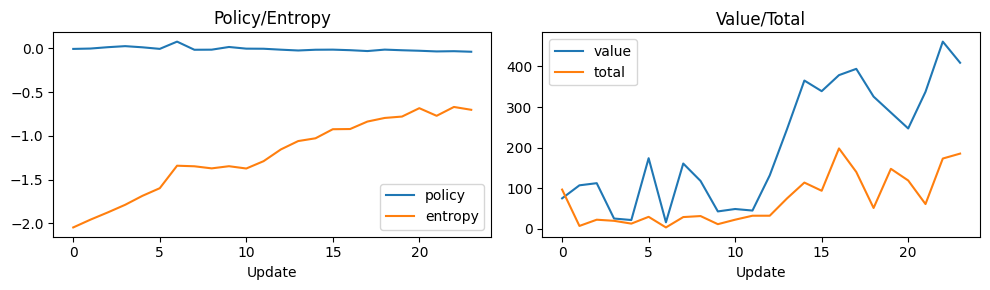

In [26]:
import csv
import os
import matplotlib.pyplot as plt

log_path = os.path.join(log_dir, "progress.csv")
if not os.path.exists(log_path):
    print(f"No progress.csv found at {log_path}. Did training run?")
else:
    with open(log_path, "r", newline="") as f:
        rows = list(csv.DictReader(f))

    def get_series(key: str):
        vals = []
        for r in rows:
            v = r.get(key, "")
            if v != "" and v is not None:
                vals.append(float(v))
        return vals

    policy_loss = get_series("train/policy_gradient_loss")
    value_loss = get_series("train/value_loss")
    entropy_loss = get_series("train/entropy_loss")
    total_loss = get_series("train/loss")

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    if policy_loss:
        axes[0].plot(policy_loss, label="policy")
    if entropy_loss:
        axes[0].plot(entropy_loss, label="entropy")
    axes[0].set_title("Policy/Entropy")
    axes[0].set_xlabel("Update")
    axes[0].legend()

    if value_loss:
        axes[1].plot(value_loss, label="value")
    if total_loss:
        axes[1].plot(total_loss, label="total")
    axes[1].set_title("Value/Total")
    axes[1].set_xlabel("Update")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


Generate a rollout GIF to visualize how the agent rotates the source image toward the target.


In [29]:
import imageio.v2 as imageio

def render_pair_frame(source: torch.Tensor, target: torch.Tensor) -> np.ndarray:
    # Return a side-by-side frame (H, 2W, 3) as uint8.
    src = (source.clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
    tgt = (target.clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
    return np.concatenate([src, tgt], axis=1)


def rollout_and_save_gif(
    env: RotationEnv,
    model: PPO,
    out_path: str = "gifs/rotation_ppo_tetris_episode.gif",
    max_steps: int = 180,
    fps: int = 8,
):
    obs, _ = env.reset()
    frames = []

    for _ in range(max_steps):
        frames.append(render_pair_frame(env.current_source, env.target))
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(int(action))
        if terminated or truncated:
            frames.append(render_pair_frame(env.current_source, env.target))
            break

    imageio.mimsave(out_path, frames, fps=fps)
    return out_path


gif_env = RotationEnv(
    image_shape=image_shape,
    max_steps=180,
    epsilon=0.01,
    device=device,
    pair_sampler=sampler,
)

gif_path = rollout_and_save_gif(gif_env, model, out_path="gifs/rotation_ppo_tetris_episode.gif")
gif_path


'gifs/rotation_ppo_tetris_episode.gif'